In [59]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf

In [60]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/btxrd-final/classification/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/btxrd-final/classification/images'
mask_path = '/kaggle/input/btxrd-final/classification/masks'
print("dfasdfd")

dfasdfd


In [61]:
# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1]

# Chia train, test, valid
df_train = df_with_mask[df_with_mask['tumor_category'] == 1].copy()
df_test  = df_with_mask[df_with_mask['tumor_category'] == 2].copy()
df_valid = df_with_mask[df_with_mask['tumor_category'] == 3].copy()
print("dfasdfd")

dfasdfd


In [62]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("dfasdfd")

dfasdfd


In [63]:
# Hàm load ảnh và mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (224, 224))
    mask = tf.image.resize(mask, (224, 224))
    return image, mask

# Chọn batch size random trước
BATCH_SIZE = random.choice([8, 16, 32, 64])

# Tạo datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
train_dataset = train_dataset.map(load_image_and_mask)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
val_dataset = val_dataset.map(load_image_and_mask)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
test_dataset = test_dataset.map(load_image_and_mask)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
print("dfasdfd")

dfasdfd


Train batch shape:
Image batch shape: (32, 224, 224, 1)
Mask batch shape: (32, 224, 224, 1)


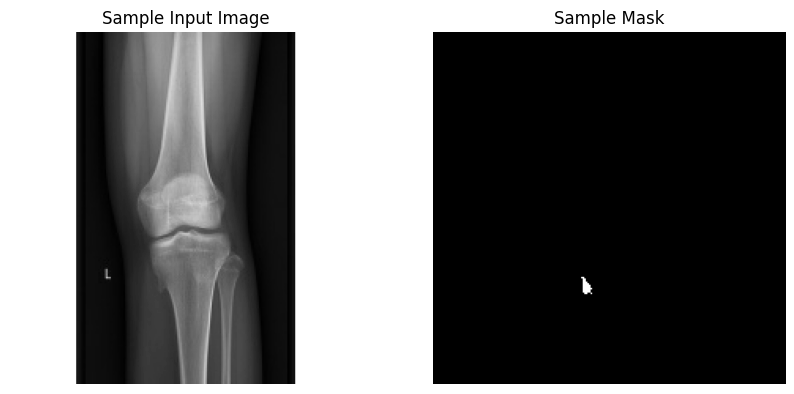

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


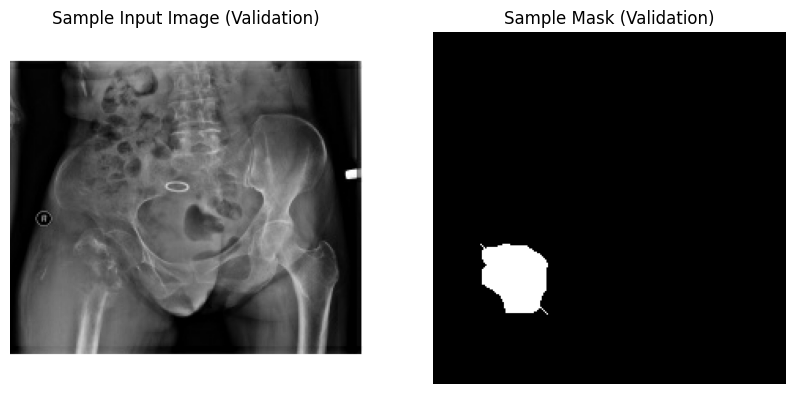

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


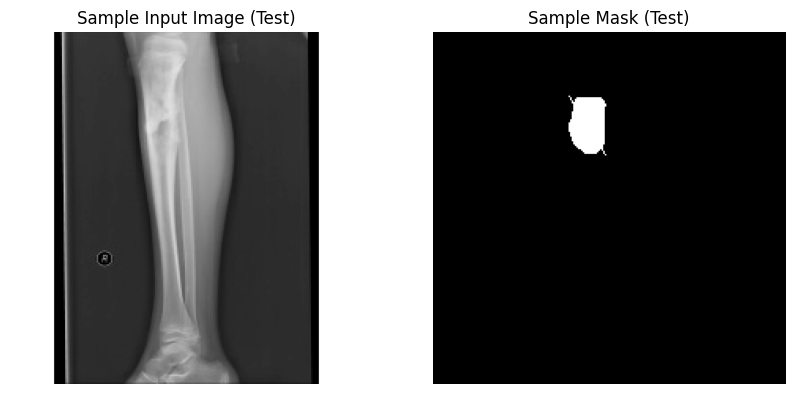

dfasdfd


In [64]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break
print("dfasdfd")

In [65]:
from PIL import Image

# Mở ảnh
image = Image.open('/kaggle/input/btxrd-final/classification/masks/IMG000001.png')

# Lấy kích thước ảnh (width, height)
width, height = image.size
print(f"Width: {width}, Height: {height}")


Width: 224, Height: 224


In [66]:
def conv_block(x, filters):
    conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

def encoder_block(x, filters):
    conv = conv_block(x, filters)
    pool = layers.MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2, 2))(x)
    merge = layers.concatenate([up, skip])
    conv = conv_block(merge, filters)
    return conv

def unet_model_deep(input_shape=(224, 224, 1), num_classes=1, num_levels=4, initial_filters=64):
    inputs = layers.Input(shape=input_shape)
    skips = []
    x = inputs
    filters = initial_filters

    # Encoder
    for _ in range(num_levels):
        conv, pool = encoder_block(x, filters)
        skips.append(conv)
        x = pool
        filters *= 2

    # Bottleneck
    x = conv_block(x, filters)

    # Decoder
    filters //= 2
    for skip in reversed(skips):
        x = decoder_block(x, skip, filters)
        filters //= 2

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Tạo mô hình U-Net sâu hơn với 4 cấp độ encoder/decoder
deep_model = unet_model_deep(num_levels=4, initial_filters=32)
deep_model.summary()

# Bạn cũng có thể tạo mô hình với số lượng cấp độ khác nhau
# very_deep_model = unet_model_deep(num_levels=5, initial_filters=16)
# very_deep_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 224, 224, 32)   │            320 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 224, 224, 32)   │          9,248 │ conv2d_113[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 112, 112, 32)   │              0 │ conv2d_114[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 112, 112, 64)   │         36,928 │ conv2d_115[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 56, 56, 64)     │              0 │ conv2d_116[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 56, 56, 128)    │        147,584 │ conv2d_117[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 28, 28, 128)    │              0 │ conv2d_118[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 28, 28, 256)    │        590,080 │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 14, 14, 256)    │              0 │ conv2d_120[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 14, 14, 512)    │      1,180,160 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 14, 14, 512)    │      2,359,808 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_21          │ (None, 28, 28, 512)    │              0 │ conv2d_122[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21       

 Total params: 7,846,081 (29.93 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Định nghĩa mô hình
model = unet_model()

# Compile mô hình với metrics phù hợp hơn
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])  # Giả sử 2 lớp (nền và đối tượng)

# Định nghĩa callbacks
checkpoint_filepath = 'unet_best_model.keras'  # Đổi tên thành .keras
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    mode='max')

early_stopping_callback = EarlyStopping(
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    patience=10,
    mode='max',
    restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    factor=0.1,
    patience=5,
    min_lr=0.00001)

callbacks = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

# Huấn luyện mô hình với callbacks
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50


In [ ]:
results = model.evaluate(test_dataset)
print(f"Results: {results}")


In [ ]:
# Dự đoán trên test dataset và hiển thị kết quả
for image_batch, mask_batch in test_dataset.take(1):  # Chỉ lấy một batch từ test dataset
    pred_batch = model.predict(image_batch)  # Dự đoán cho batch
    pred_batch = (pred_batch > 0.5).astype(np.float32)  # Chuyển sang nhị phân (0 hoặc 1)

    # Hiển thị ảnh gốc, mask thực tế và mask dự đoán
    plt.figure(figsize=(12, 12))
    for i in range(min(4, len(image_batch))):  # Chỉ hiển thị 4 ảnh đầu tiên
        # Ảnh gốc
        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(image_batch[i, :, :, 0], cmap='gray')
        plt.title("Image")
        plt.axis('off')

        # Mask thực tế
        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(mask_batch[i, :, :, 0], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Mask dự đoán
        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(pred_batch[i, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()


In [ ]:
model.save('unet_model.h5')  # Lưu mô hình dưới dạng file .h5
model.save('/kaggle/working/unet_model.h5')  # Lưu mô hình vào thư mục /kaggle/working

In [ ]:
from IPython.display import FileLink

# Tạo liên kết tải xuống cho file mô hình
FileLink('/kaggle/working/unet_model.h5')